# Training loss

In [ ]:
%pip install --upgrade https://github.com/remifan/commplax/archive/master.zip
%pip install --upgrade https://github.com/remifan/LabPtPTm2/archive/master.zip
%pip install --upgrade https://github.com/remifan/gdbp_study/archive/master.zip

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from commplax import equalizer as eq, xcomm, plot as cplt
from gdbp import gdbp_base as gb, data as gdat, plot as gplt

In [3]:
data = gdat.load(1, 0, 4, 2)[0]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
def train_gdbp(data, dtaps=261, ntaps=41):
  gdbp = gb.model_init(data, {'ntaps': ntaps, 'dtaps': dtaps, 'init_fn': gb.fdbp_init(data.a, xi=1.1, steps=3)}, [])
  return list(zip(*list(gb.train(gdbp, data, n_iter=2000))))


def train_fdbp(data, dtaps=261, ntaps=41):
  gdbp = gb.model_init(data, {'ntaps': ntaps, 'dtaps': dtaps, 'init_fn': gb.fdbp_init(data.a, xi=1.1, steps=3)}, [('fdbp_0',)])
  return list(zip(*list(gb.train(gdbp, data, n_iter=2000))))


def tree_diff(trees, **kwargs):
  diff = [jax.tree_map(lambda a, b: np.mean(np.abs(a - b)**2)/np.mean(np.abs(b)**2),
                       trees[i], trees[-1], **kwargs) for i in range(len(trees)-1)]
  return jax.tree_map(lambda *xs: list(xs), *diff)

In [12]:
loss_gdbp, params, state = train_gdbp(data)
loss_fdbp = train_fdbp(data)[0]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
params_diff = tree_diff(params)
state_diff = tree_diff(state)

(<matplotlib.patches.Rectangle at 0x7f177c62a2b0>,
 (<matplotlib.patches.ConnectionPatch at 0x7f177c70f370>,
  <matplotlib.patches.ConnectionPatch at 0x7f177c713eb0>))

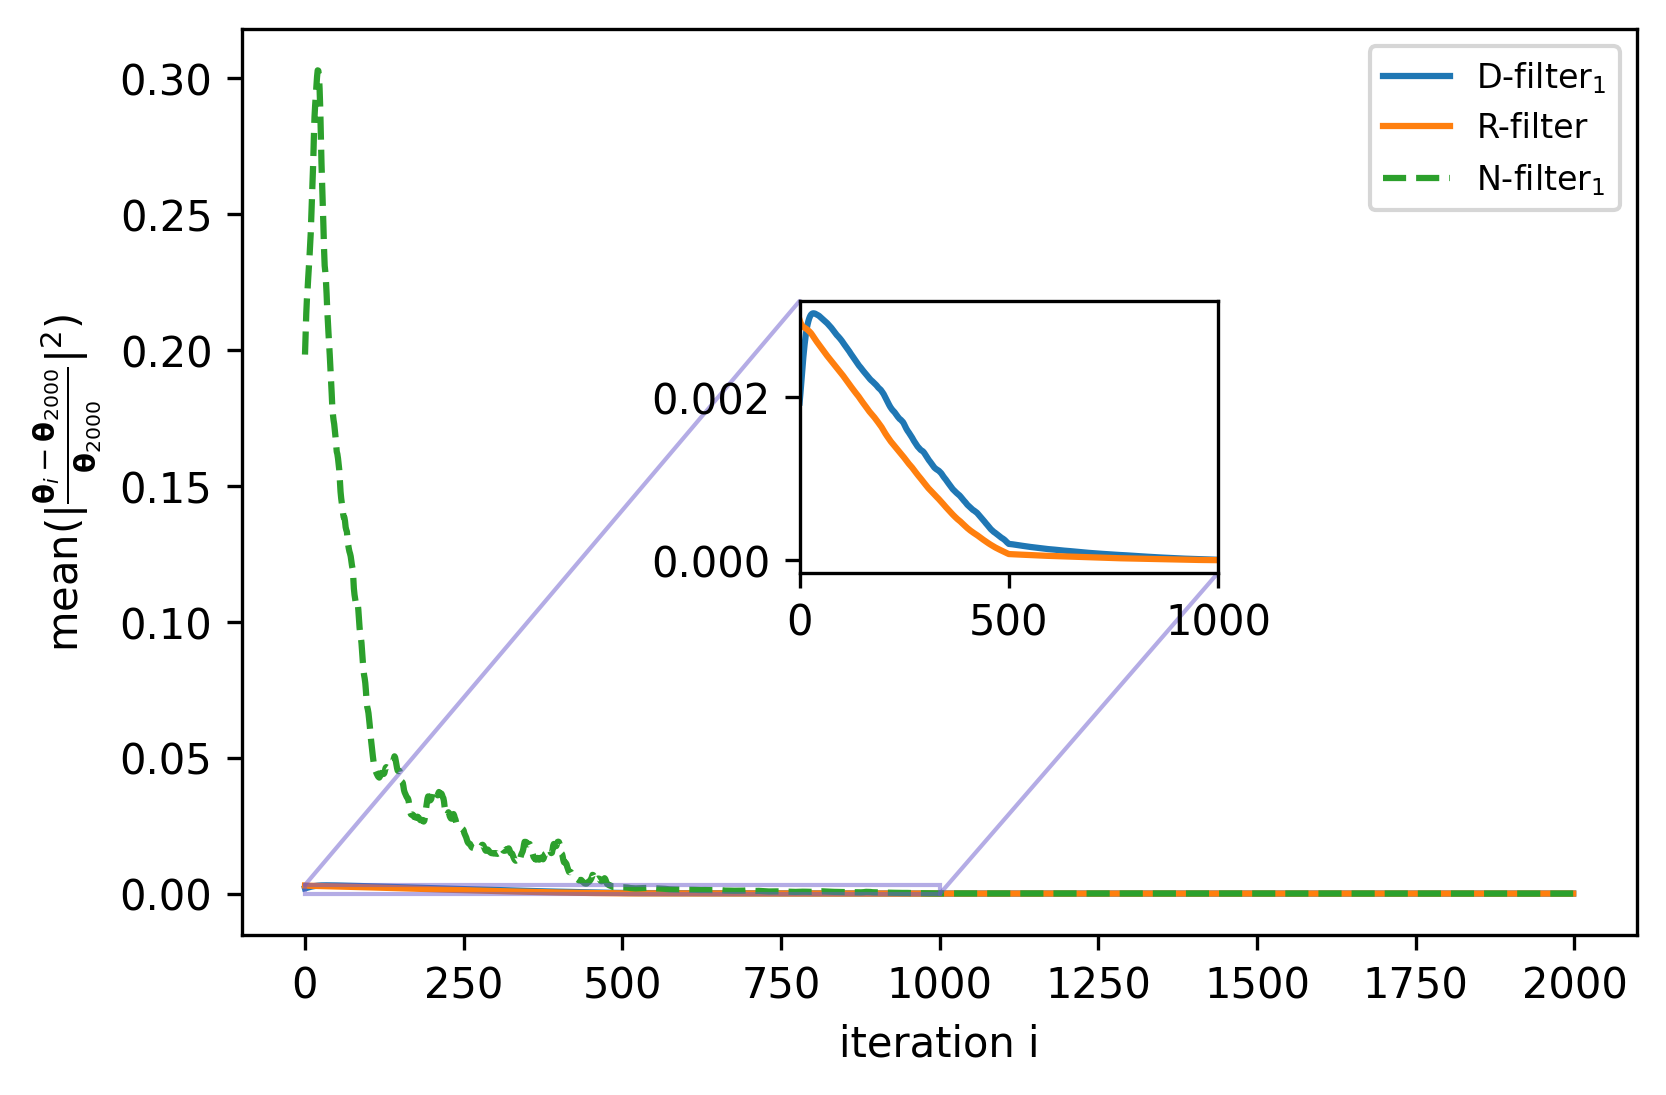

In [34]:
plt.figure(figsize=(6, 4), dpi=300)
sli = slice(0, 2000)
ax1 = plt.gca()
ax1.plot(params_diff['fdbp_0']['DConv_0']['kernel'][sli], label=r'D-filter$_1$')
ax1.plot(params_diff['RConv']['kernel'][sli], label=r'R-filter')
ax1.plot(params_diff['fdbp_0']['NConv_0']['kernel'][sli], '--', label=r'N-filter$_1$', markersize=1)
ax1.legend(fontsize=8, loc='lower left')
ax1.set_ylabel(r'mean(|$\frac{\mathbf{\theta}_i - \mathbf{\theta}_{2000}}{\mathbf{\theta}_{2000}}|^2$)')
ax1.set_xlabel('iteration i')
ax1.legend(fontsize=8)

axins = ax1.inset_axes([0.4, 0.4, 0.3, 0.3])
axins.plot(params_diff['fdbp_0']['DConv_0']['kernel'], label=r'D-filter$_1$')
axins.plot(params_diff['RConv']['kernel'], label=r'R-filter')
axins.set_xlim(0, 1000)
# axins.set_ylim(2.92, 3.4)
axins.set_xticks([0, 500, 1000])
ax1.indicate_inset_zoom(axins, edgecolor="slateblue")

In [35]:
def loss(loss, ax=None, label=None, alpha=0.4):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    loss_mean = np.convolve(loss, np.ones(20) / 20, mode='same')
    p = ax.plot(loss[:], alpha=alpha, label=label)
    ax.plot(loss_mean[:-50], color=p[0].get_color())
    ax.set_xlabel('iteration')
    ax.set_ylabel('MSE')
    ax.legend()

(0.023, 0.045)

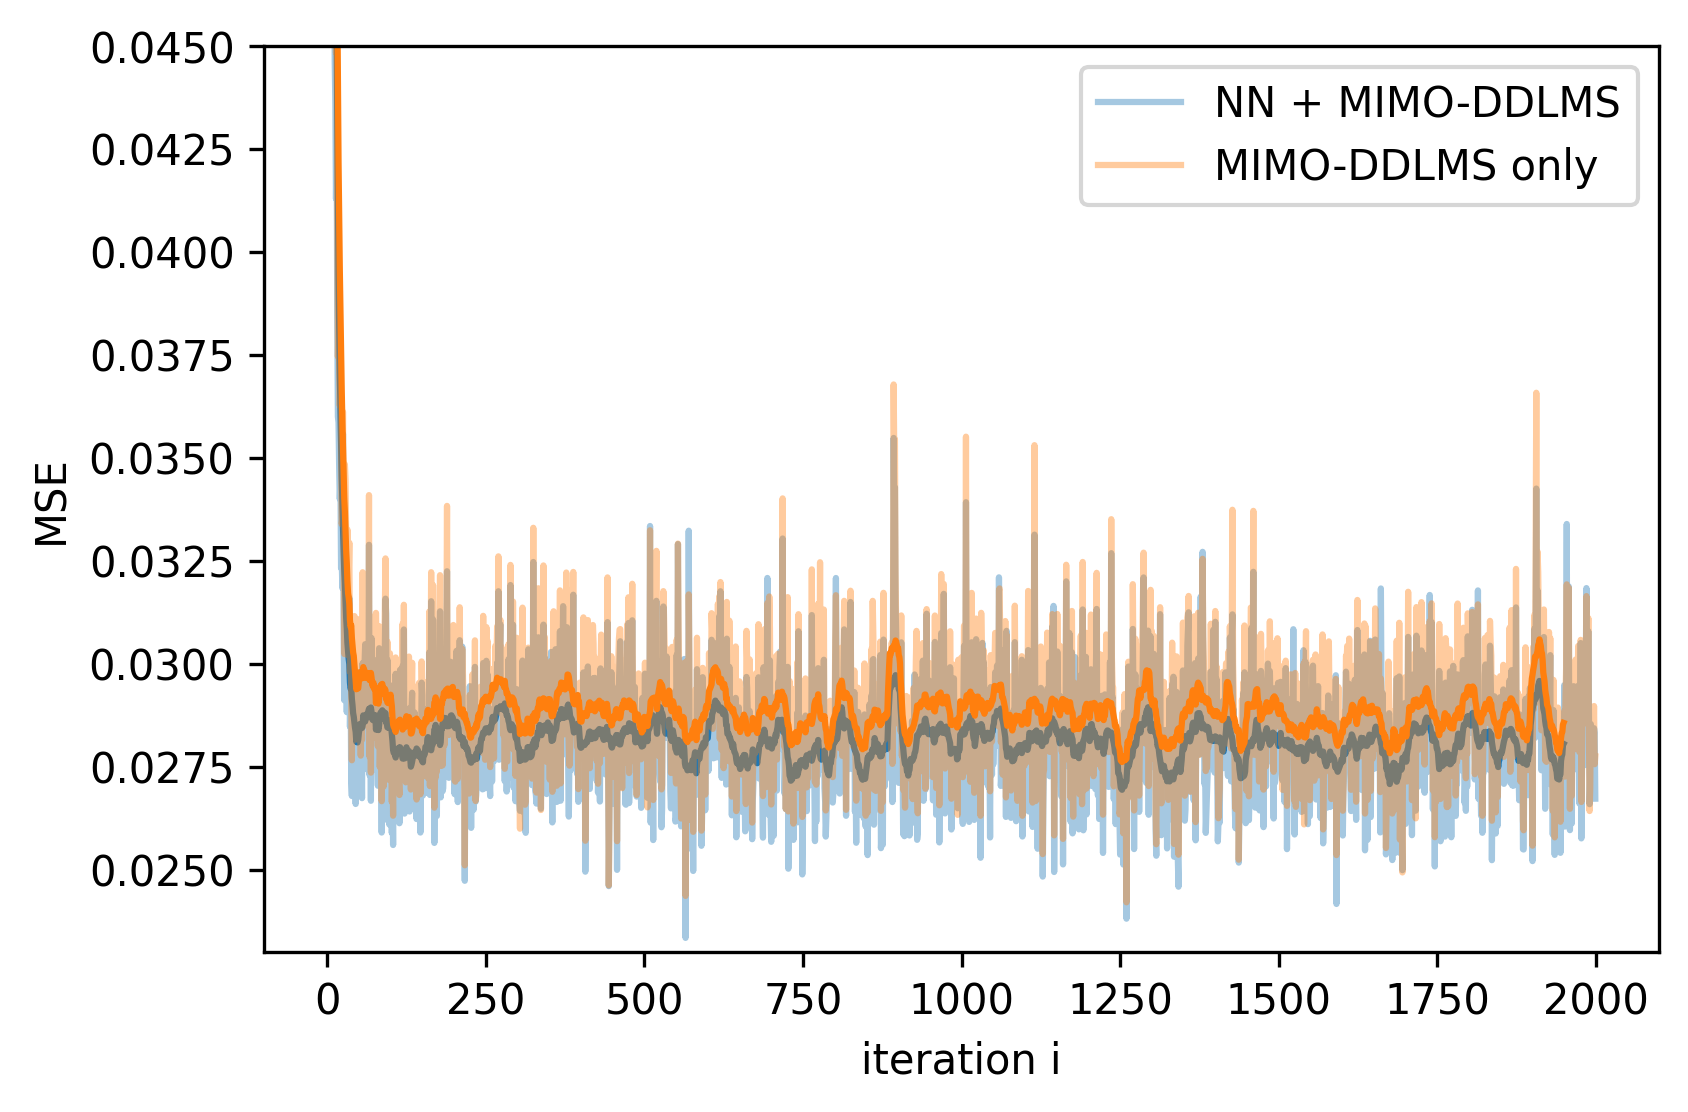

In [36]:
plt.figure(figsize=(6, 4), dpi=300)
ax = plt.gca()
loss(loss_gdbp, ax=ax, label='NN + MIMO-DDLMS')
loss(loss_fdbp, ax=ax, label='MIMO-DDLMS only')
ax.set_xlabel('iteration i')
ax.set_ylim([0.023, 0.045])